In [1]:
%load_ext version_information

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import emcee

from numpy import random
from scipy import stats, optimize
from matplotlib.ticker import MaxNLocator
from corner import corner

%version_information numpy, scipy, matplotlib, seaborn, emcee, corner

Software versions
Python 3.8.6 64bit [Clang 11.0.0 (clang-1100.0.33.16)]
IPython 7.19.0
OS macOS 10.15.7 x86_64 i386 64bit
numpy 1.19.4
scipy 1.5.4
matplotlib 3.3.3
seaborn 0.11.2
emcee 3.0.2
corner 2.1.0
Thu Nov 18 10:10:25 2021 GMT

### Theme setup

In [3]:
sns.set_theme(style='ticks', palette='colorblind', font_scale=1.2)  # Set theme
plt.set_cmap('Blues')  # Set default color map

<Figure size 432x288 with 0 Axes>

## Normal distribution

If some random variable $y$ is normally distributed, its probability density function $p(y) = \mathcal{N}(\mu, \sigma^2)$ where,

$$\mathcal{N}(\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(y - \mu)^2}{2\sigma^2}\right],$$

$\mu$ is the mean, and $\sigma^2$ is the variance ($\sigma$ is the standard deviation). We may paraphrase this by writing that a given $y$ is drawn from a normal distribution like this,

$$y \sim \mathcal{N}(\mu, \sigma^2).$$

We can draw (pseudo) random numbers from this distribution with `numpy`.

In [127]:
def normal(y, loc=0.0, scale=1.0):
    return (2*np.pi)**-0.5/scale * np.exp(-0.5*((y - loc)/scale)**2)

In [128]:
seed = 0
rng = random.default_rng(seed)

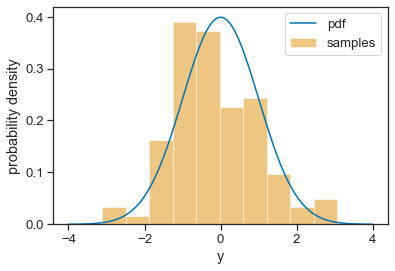

In [132]:
mean = 0.0
sigma = 1.0

y = np.linspace(-4, 4, 101)
density = normal(y, loc=mean, scale=sigma)

num_samples = 100
rvs = rng.normal(loc=mean, scale=sigma, size=num_samples)

plt.plot(y, density, label='pdf')
plt.hist(rvs, bins=10, density=True, alpha=0.5, label='samples')
plt.xlabel('y')
plt.ylabel('probability density')
plt.legend();

## Multivariate normal distribution

The multivariate normal distribution is the general case for the above for $n$-dimensional variable $\boldsymbol{y} = y_0, y_1, \dots, y_{n-1}$.

$$\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{\sqrt{(2\pi)^{n}|\boldsymbol{\Sigma}|}}\exp\left[-\frac12 (\boldsymbol{y} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\boldsymbol{y} - \boldsymbol{\mu})\right]$$

$$p(\boldsymbol{y}) = \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$$

This is a little more complicated to code up, so we use the `scipy.stats` package.

In [139]:
def mv_normal(y, mean, cov):
    """N-dimensional multivariate normal probability density function
    p(y) = N(mean, cov).
    
    Args:
        y (array_like): Array of coordinates to evaluate the pdf with length N.
        mean (array_like): The mean of the MV Normal (1-D array of size N)
        cov (array_like): The covariance of the MV Normal (2-D array of shape (N, N)).
    
    Returns:
        np.ndarray: N-D array of probability density.
    """
    Y = np.meshgrid(*y)
    x = np.stack(Y, axis=-1)
    
    density = stats.multivariate_normal.pdf(x, mean=mean, cov=cov)
    return density


def grid(mean, cov, num_points=201, width_factor=3.0):
    """A grid of points y with shape (N, M) goverened by a window
    around the mean with width determined by the covariance.
    
    Args:
        mean (array_like): The mean of y (1-D array of size N)
        cov (array_like): The covariance of y (2-D array of shape (N, N)).
        num_points (int): The number of points in an axis of the grid (M).
        width_factor (float): The factor to multiply sigma for the width of
            each axis.
    
    Returns:
        y (np.ndarray): A N x M grid of points.
    """
    sigma = np.sqrt(np.diag(cov))
    y = np.linspace(mean-width_factor*sigma, mean+width_factor*sigma, num_points, axis=1)
    return y

### Joint distribution

Let's consider a 2-D multivariate normal, $\boldsymbol{y} = [y_0, y_1]$, variables $y_0$ and $y_1$ go as,

$$
\begin{bmatrix}
    y_0 \\ y_1
\end{bmatrix}
\sim \mathcal{N} \left(
\begin{bmatrix}
    \mu_0 \\ \mu_1
\end{bmatrix},
\begin{bmatrix}
    \Sigma_{0,0} & \Sigma_{0,1} \\
    \Sigma_{1,0} & \Sigma_{1,1}
\end{bmatrix}
\right)
$$

where the mean,

$$\mu_i = \mathbb{E}[y_i]$$

and the covariance,

$$\Sigma_{i,j} \equiv \mathrm{cov}(y_i, y_j) = \mathbb{E}[(y_i - \mu_i)\cdot(y_j - \mu_j)]$$

The variance is just a special case of the covariance for $i=j$,

$$\sigma_i^2 \equiv \mathrm{var}(y_i) = \mathbb{E}[(y_i - \mu_i)^2]$$

For an $N$-dimensional multivariate normal in $\boldsymbol{y}$, the joint (or 2-D marginal) distribution is integrated over all $\boldsymbol{y}_{k} = \{y_k\}$ where $k \neq i,j$,

$$p(y_i, y_j) = \int_{\boldsymbol{y}_{k}} p(\boldsymbol{y}) \, \mathrm{d}\boldsymbol{y}_{k}.$$

If we evaluate this integral we get the 2-D multivariate normal,

$$p(y_i, y_j) = \mathcal{N} \left(
\begin{bmatrix}
    \mu_i \\ \mu_j
\end{bmatrix},
\begin{bmatrix}
    \Sigma_{i,i} & \Sigma_{i,j} \\
    \Sigma_{j,i} & \Sigma_{j,j}
\end{bmatrix}
\right)
$$

In [200]:
def get_joint(y, mean, cov, i=0, j=1):
    """Get joint distribution p(y_i, y_j).
    
    Args:
        y (array_like): Array of coordinates to evaluate the pdf with length N.
        mean (array_like): The mean of y (1-D array of size N)
        cov (array_like): The covariance of y (2-D array of shape (N, N)).
        i, j (int): Indices in joint distribution.
    
    Returns:
        np.ndarray: 2-D array of joint probability density.
    """
    mean = np.array(mean)
    joint_mean = mean[[i, j]]

    cov = np.array(cov)
    joint_cov = [
        [cov[i, i], cov[i, j]],
        [cov[j, i], cov[j, j]]
    ]
    return mv_normal([y[i], y[j]], joint_mean, joint_cov)    


def plot_joint(y, mean, cov, i=0, j=1, ax=None, cax=None):
    """Plots the joint distribution, p(y_i, y_j).

    Args:
        y (array_like): Array of coordinates to evaluate the pdf with length N.
        mean (array_like): The mean of y (1-D array of size N)
        cov (array_like): The covariance of y (2-D array of shape (N, N)).
        i, j (int): Indices in joint distribution.
        vertical (bool): Display distribution vertically.
        ax (matplotlib.axes.Axes, optional): Axes object to make plot.
    
    Returns:
        matplotlib.axes.Axes: Plot axis.
    """
    if ax is None:
        ax = plt.gca()
    
    assert i != j
    
#     axis = tuple(set(range(density.ndim)) - set((i, j)))
#     joint = np.sum(density, axis=axis)
#     joint /= integrate.trapz(integrate.trapz(joint, y[j]), y[i])
#     yy = [y[i], y[j]]

#     mean = np.array(mean)
#     joint_mean = mean[[i, j]]

#     cov = np.array(cov)
#     joint_cov = [
#         [cov[i, i], cov[i, j]],
#         [cov[j, i], cov[j, j]]
#     ]
    joint = get_joint(y, mean, cov, i=i, j=j)
    
    c = ax.contourf(y[i], y[j], joint)
    ax.set_xlabel(rf'$y_{i}$')
    ax.set_ylabel(rf'$y_{j}$')

    cbar = plt.colorbar(c, cax=cax, pad=0.075)
    cbar.set_label('probability density')
    
    return ax

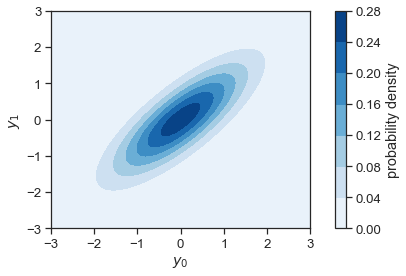

In [258]:
mean = np.zeros(2)
cov = np.array([[1.0, 0.8],
       [0.8, 1.0]])

# y, density = mv_normal_grid(mean, cov)
y = grid(mean, cov)
ax = plot_joint(y, mean, cov)

### Marginal distribution

A marginal distribution is just one in which parameters in the full distribution have been integrated out (as we saw with the joint distribution). If our full distribution is $p(y_0, y_1)$ then the marginal distribution for $y_0$ is,

$$p(y_0) = \int p(y_0, y_1) \, \mathrm{d}y_1.$$

If we evaluate this integral we get the normal distribution,

$$y_0 \sim \mathcal{N}(\mu_0, \sigma_{0}^2)$$

where $\sigma_{0}^2 \equiv \Sigma_{0, 0}$.

In [202]:
def get_marginal(y, mean, cov, j=0):
    """Gets the marginal distribution p(y_j).
    
    Args:
        y (array_like): Array of coordinates to evaluate the pdf with length N.
        mean (array_like): The mean of y (1-D array of size N)
        cov (array_like): The covariance of y (2-D array of shape (N, N)).
        j (int): Index to marginalise out.
    
    Returns:
        np.ndarray: 1-D array of marginal probability density.
    """
    loc = mean[j]
    cov = np.array(cov)
    scale = cov[j, j]
    return normal(y[j], loc=loc, scale=scale)
    
    
def plot_marginal(y, mean, cov, j=0, vertical=True, ax=None):
    """Plots the marginal distribution p(y_j).
    
    Args:
        y (array_like): Array of coordinates to evaluate the pdf with length N.
        mean (array_like): The mean of y (1-D array of size N)
        cov (array_like): The covariance of y (2-D array of shape (N, N)).
        j (int): Index to marginalise out.
        vertical (bool): Display distribution vertically.
        ax (matplotlib.axes.Axes, optional): Axes object to make plot.
        
    Returns:
        matplotlib.axes.Axes: Plot axis.
    """
    if ax is None:
        ax = plt.gca()
    
#     axis = np.arange(density.ndim)
#     axis = tuple(axis[axis != j])
#     marginal = np.sum(density, axis=axis)
#     marginal /= integrate.trapz(marginal, x=y[j])
#     loc = mean[j]
#     cov = np.array(cov)
#     scale = cov[j, j]
    marginal = get_marginal(y, mean, cov, j=j)
    
    X, Y = (y[j], marginal)
    xaxis, yaxis = (ax.xaxis, ax.yaxis)
    if vertical:
        X, Y = Y, X
        xaxis, yaxis = yaxis, xaxis

    ax.plot(X, Y, label=rf'$p(y_{j})$')
    
    xaxis.set_label_text(rf'$y_{j}$')
    yaxis.set_label_text('probability density')
    
    return ax

def plot_joint_marginal(y, mean, cov, i=0, j=1, fig=None):
    """Plots the joint distribution p(y_i, y_j) and the
    marginal distribution p(y_j) in the same figure.
    
    Args:
        y (array_like): Array of coordinates to evaluate the pdf with length N.
        mean (array_like): The mean of y (1-D array of size N)
        cov (array_like): The covariance of y (2-D array of shape (N, N)).
        i, j (int): Indices in joint distribution.
        vertical (bool): Display distribution vertically.
        fig (matplotlib.figure.Figure, optional): Figure object to make plot.
    
    Returns:
        matplotlib.figure.Figure: Figure object.
    """
    if fig is None:
        width_ratios = [1.0, 0.625, 0.075]
        sf = 5  # scale factor for plot size
        figsize = sf * np.array([sum(width_ratios), width_ratios[0]])
        fig = plt.figure(figsize=figsize)

    gs = fig.add_gridspec(1, 3, wspace=0.1, width_ratios=width_ratios)

    ax0 = fig.add_subplot(gs[0])
    cax = fig.add_subplot(gs[2])
    ax0 = plot_joint(y, mean, cov, i=i, j=j, ax=ax0, cax=cax)

    ax1 = fig.add_subplot(gs[1], sharey=ax0)
    ax1 = plot_marginal(y, mean, cov, j=j, ax=ax1)
    ax1.tick_params(labelleft=False)
    ax1.yaxis.label.set_visible(False)

    return fig 

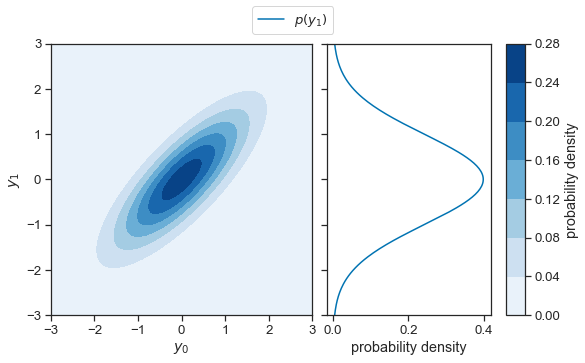

In [205]:
fig = plot_joint_marginal(y, mean, cov)
fig.legend(loc='upper center');

### Conditional distribution

The conditional distribution of $y_1$ given some value of $y_0$ is given by the joint distribution over the marginal distribution,

$$p(y_1 | y_0) = \frac{p(y_0, y_1)}{p(y_0)}.$$

We will later show what this evaluates to, but for now we will just numerically calculate it.

In [257]:
def plot_conditional(y, mean, cov, i=0, j=1, fig=None):
    """Plot the conditional distribution of y_j given y_i, 
    p(y_j | y_i).
    
    Args:
        y (list of array_like): Coordinates of the MV normal
            where y[i] must be a float and all other indeces
            must be array_like.
        mean (array_like): The mean of y (1-D array of size N)
        cov (array_like): The covariance of y (2-D array of shape (N, N)).
        i (int): Index of the condition.
        j (int): Index of the conditional variable.
        fig (matplotlib.figure.Figure, optional): Figure object to make plot.
    
    Returns:
        matplotlib.figure.Figure: Figure object.    
    """
    if fig is None:
        fig = plt.gcf()
    
    joint = get_joint(y, mean, cov, i=i, j=j)
    marginal = get_marginal(y, mean, cov, j=i)

    cond = joint/marginal

    axes = fig.get_axes()
    axes[0].axvline(y[i], color='C1', label=rf'$y_{i} = {y[i]:.1f}$')
    axes[2].plot(cond, y[j], color='C1', linestyle='--', label=rf'$p(y_{j} | y_{i} = {y[i]:.1f})$')
    return fig

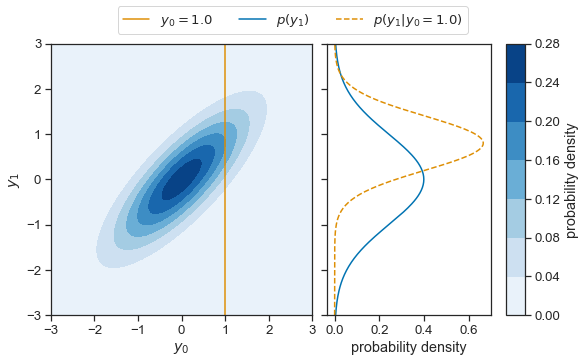

In [259]:
y_cond = list(y)
y_cond[0] = 1.0

# density_cond = mv_normal(y_cond, mean=mean, cov=cov)

fig = plot_joint_marginal(y, mean, cov)
fig = plot_conditional(y_cond, mean, cov, fig=fig)
fig.legend(loc='upper center', ncol=3);

## Random variables

Now let's draw random variables from the distribution. We do this with the `numpy.random` module.

Firstly, we define some helper functions for plotting the samples and relationship between them.

In [226]:
def plot_samples(samples, i=0, j=1, ax=None):
    """Plot the samples[i] against samples[j].   

    Args:
        samples (array_like): Array of samples.
        i, j (int): Indices of samples to plot.
        ax (matplotlib.axes.Axes): Axis on which to plot.
        
    Returns:
        matplotlib.axes.Axes: Plotting axis.
    """
    alpha = 1/samples.shape[0]**0.1
    if ax is None:
        ax = plt.gca()
    ax.plot(*samples[:, [i, j]].T, color='C1', marker='o', linestyle='none', alpha=alpha, label='samples')
    return ax

def plot_relation(samples, ax=None):
    """Plot the relationship between each index of samples.
    
    Args:
        samples (array_like): Array of samples.
        ax (matplotlib.axes.Axes): Axis on which to plot.
        
    Returns:
        matplotlib.axes.Axes: Plotting axis.
    """
    alpha = 1/samples.shape[0]**0.1
    if ax is None:
        ax = plt.gca()
    ax.plot(samples.T, color='C1', marker='o', alpha=alpha)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel('index')
    ax.set_ylabel('$y_i$')
    return ax

### Correlated distribution

We see that the choice of $y_0$ correlates with that of $y_1$.

(-0.5, 1.5)

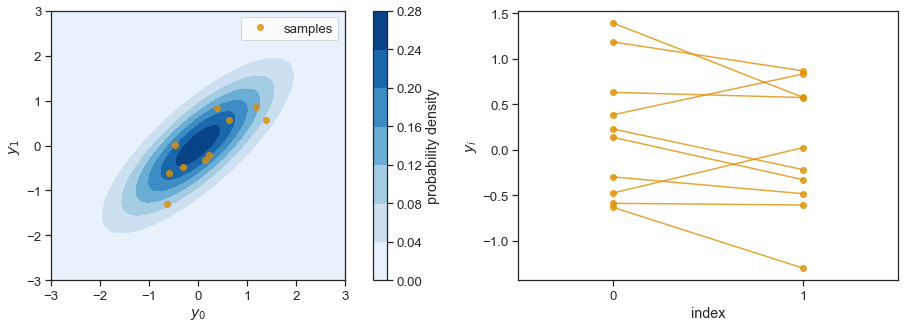

In [260]:
num_samples = 10
samples = rng.multivariate_normal(mean, cov, size=num_samples)

figsize = plt.rcParamsDefault['figure.figsize'].copy()
figsize[0] *= 2
fig = plt.figure(figsize=figsize, tight_layout=True)

ax = fig.add_subplot(1, 2, 1)
ax = plot_joint(y, mean, cov, ax=ax)
ax = plot_samples(samples, ax=ax)
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax = plot_relation(samples, ax=ax)
ax.set_xlim(-0.5, 1.5)

### Uncorrelated distribution

For the uncorrelated case, the conditional distribution is the same everywhere.

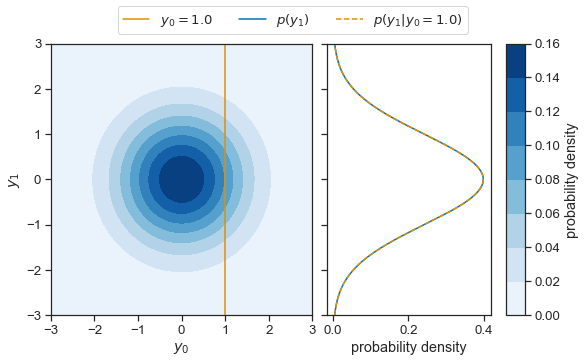

In [261]:
mean = np.zeros(2)
cov = [[1.0, 0.0],
       [0.0, 1.0]]
y = grid(mean, cov)

y_cond = list(y)
y_cond[0] = 1.0

fig = plot_joint_marginal(y, mean, cov)
fig = plot_conditional(y_cond, mean, cov, fig=fig)
fig.legend(loc='upper center', ncol=3);

We can see this when we take random samples. There is no correlation between $y_0$ and $y_1$.

(-0.5, 1.5)

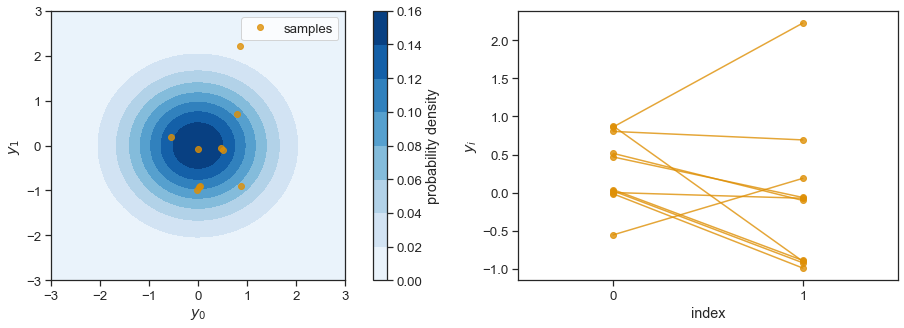

In [263]:
num_samples = 10
samples = rng.multivariate_normal(mean, cov, size=num_samples)

figsize = plt.rcParamsDefault['figure.figsize'].copy()
figsize[0] *= 2
fig = plt.figure(figsize=figsize, tight_layout=True)

ax = fig.add_subplot(1, 2, 1)
ax = plot_joint(y, mean, cov, ax=ax)
ax = plot_samples(samples, ax=ax)
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax = plot_relation(samples, ax=ax)
ax.set_xlim(-0.5, 1.5)

### Adding dimensions

Now lets add some dimensions to the distribution. We need a helper function which gives us a valid covariance matrix.

In [264]:
def covariance(index):
    """Get a covariance matrix for a given array of indices.

    Args:
        index (array_like): Array of indeces. 
    
    Returns:
        np.ndarray: Covariance matrix.
    """
    index = np.array(index)
    return np.exp(-0.5 * (index[:, None] - index)**2/index.size)


def plot_covariance(cov, ax=None):
    """Plot the covariance matrix.
    
    Args:
        cov (array_like): Covariance matrix.
        ax (matplotlib.axes.Axes, optional). Axis on which to plot.
    
    Returns:
        matplotlib.axes.Axes: Plotting axis.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    matrix = ax.matshow(cov)
    ax.set_ylabel('index')
    ax.set_xlabel('index')
    ax.xaxis.set_label_position('top') 

    cbar = plt.colorbar(matrix)
    cbar.set_label('covariance')
    
    return ax

(-0.5, 2.5)

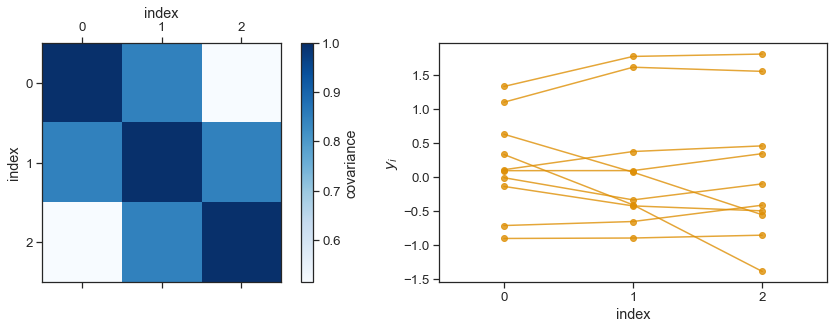

In [265]:
num_dims = 3
index = np.arange(num_dims)
mean = np.zeros(num_dims)
cov = covariance(index)  # Creates an example, covarience matrix for given index.

num_samples = 10
samples = rng.multivariate_normal(mean, cov, size=num_samples)

fig = plt.figure(figsize=figsize, tight_layout=True)

ax = fig.add_subplot(1, 2, 1)
ax = plot_covariance(cov, ax=ax);

ax = fig.add_subplot(1, 2, 2)
ax = plot_relation(samples, ax=ax)
ax.set_xlim(-0.5, num_dims-0.5);

Let's plot the joint distribution. Change `i` and `j` to see how the distributions vary.

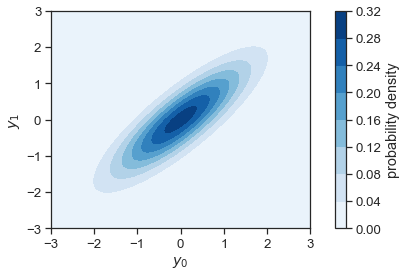

In [273]:
y = grid(mean, cov)

i, j = (0, 1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = plot_joint(y, mean, cov, i=i, j=j, ax=ax);

Now let's try even more dimensions! The relationship plot is begining to look like a smooth function.

(-0.5, 9.5)

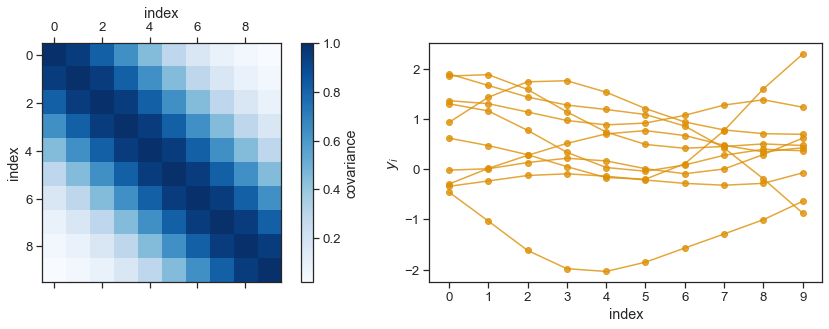

In [236]:
num_dims = 10
index = np.arange(num_dims)
mean = np.zeros(num_dims)
cov = covariance(index)

num_samples = 10
samples = rng.multivariate_normal(mean, cov, size=num_samples)

fig = plt.figure(figsize=figsize, tight_layout=True)

ax = fig.add_subplot(1, 2, 1)
ax = plot_covariance(cov, ax=ax);

ax = fig.add_subplot(1, 2, 2)
ax = plot_relation(samples, ax=ax)
ax.set_xlim(-0.5, num_dims-0.5)

## Gaussian process

The Gaussian process condition is that some function $f(x)$ is correlated with it's value at $x'$ according to a mean function, $m$ and kernel function $k$,

$$f(\boldsymbol{x}) \sim \mathcal{GP}[m(\boldsymbol{x}), k(\boldsymbol{x}, \boldsymbol{x}')].$$

If we make measurements $\boldsymbol{y}$ of the function at an array of points $\boldsymbol{x}$, then to satisfy the GP condition we say the points $\boldsymbol{y}$ must be drawn from the multivariate normal distribution,

$$\boldsymbol{y} \sim \mathcal{N}(\boldsymbol{m}, \boldsymbol{K}).$$

where $\boldsymbol{m} = m(\boldsymbol{x})$ and $\boldsymbol{K} = k(\boldsymbol{x}, \boldsymbol{x})$.

$$\boldsymbol{K} = 
\begin{bmatrix}
    K_{00} & K_{01} & \dots \\
    K_{10} & \dots & \dots \\
    \dots & \dots & \dots
\end{bmatrix}
$$

The mean function represents the behaviour of the function we would expect if there was no correlated noise. The kernel function represents the covarience (or correlation) between the value of the function at different values of $x$. There are many kernel functions to choose from, but we will start with a simple example called the Squared Exponential Kernel,

$$K_{ij} = \sigma^2 \exp\left[- \frac{(x_i - x_j)^2}{2\lambda^2}\right],$$

where $\sigma$ and $\lambda$ are the kernel scale and lengthscale respectively.

### Predictions

To satisfy the GP condition, the value of the function, $\boldsymbol{y}_\star$ evaluated at $\boldsymbol{x}_\star$ are correlated with $\boldsymbol{y}$, and are a part of the joint distribution,

$$
\begin{bmatrix}
    \boldsymbol{y} \\ \boldsymbol{y}_\star
\end{bmatrix}
\sim \mathcal{N} \left(
\begin{bmatrix}
    \boldsymbol{m} \\ \boldsymbol{m}_\star
\end{bmatrix},
\begin{bmatrix}
    \boldsymbol{K} & \boldsymbol{K}_\star \\
    \boldsymbol{K}_\star^T & \boldsymbol{K}_{\star\star}
\end{bmatrix}
\right),
$$

where $\boldsymbol{K}_\star = k(\boldsymbol{x}, \boldsymbol{x}_\star)$ and $\boldsymbol{K}_{\star\star} = k(\boldsymbol{x}_\star, \boldsymbol{x}_\star)$. Using the conditional distribution equation, $p(y_\star | y) = p(y, y_\star) / p(y)$, it can be derived that,

$$
\boldsymbol{y}_\star | \boldsymbol{y} \sim \mathcal{N}(\boldsymbol{\mu}_\star, \boldsymbol{\Sigma}_\star)
$$

where,

$$
\begin{align}
\boldsymbol{\mu}_\star &= \boldsymbol{m}_\star + \boldsymbol{K}_\star \cdot \boldsymbol{K}^{-1} \cdot (\boldsymbol{y} - \boldsymbol{m}) \\
\boldsymbol{\Sigma}_\star &= \boldsymbol{K}_{\star\star} - \boldsymbol{K}_\star \cdot \boldsymbol{K}^{-1} \cdot \boldsymbol{K}_\star^T 
\end{align}
$$

In [22]:
def jitter(x, delta=1e-6):
    """A small amount to add to the diagonal of the covariance."""
    return delta * np.eye(x.shape[0])


def squared_exponential(x, xp, sigma=1.0, length=1.0):
    """The squared exponential kernel function.
    
    Args:
        x (array_like): Array of x.
        xp (array_like): Array of x'.
        sigma (float): The kernel amplitude.
        length (float): The kernel length scale.
        
    Returns:
        np.ndarray: 2-D covariance matrix.
    """
    return sigma**2 * np.exp(- 0.5 * (x[:, np.newaxis] - xp)**2 / length**2)


def predict(x_pred, x, y, *, mean, kernel):
    """TODO: Make a prediction from the GP governed by a given kernel.
    
    Args:
        x_pred (array_like): Array of x-values at which to make predictions.
        x (array_like): Array of x-values for known y-values.
        y (array_like): Array of known y-values.
        mean (callable): Mean function.
        kernel (callable): Kernel function.
    
    Returns:
        np.ndarray: 1-D prediction mean.
        np.ndarray: 2-D prediction covariance.

    Hints:
        1. Firstly, compute the three kernels K.
        2. Inverting a matrix can be done with np.linalg.inv().
        2. Use np.dot() to compute the dot product.
        3. Add jitter(x) and jitter(x_pred) to k(x, x) and k(x_pred, x_pred)
            to ensure that it is positive semidefinite. 
    """
    Kxx = kernel(x, x) + jitter(x)
    Kxp = kernel(x, x_pred)
    Kpp = kernel(x_pred, x_pred) + jitter(x_pred)
    Kxx_inv = np.linalg.inv(Kxx)
        
    mu_pred = mean(x_pred) + np.dot((y - mean(x)), np.dot(Kxx_inv, Kxp))
    cov_pred = Kpp - np.dot(Kxp.T, np.dot(Kxx_inv, Kxp))
    
    return mu_pred, cov_pred

To keep our life simple, we will consider the case where the mean function $m(\boldsymbol{x}) = \boldsymbol{0}$ (using `np.zeros_like`.

In the folowing cell, define a function.

In [287]:
num_obs = 10
x_low, x_high = (0, 10)
x = rng.uniform(x_low, x_high, size=num_obs)  # Observed x

num_pred = 51
x_pred = np.linspace(x_low, x_high, num_pred)  # Unobserved x

def f(x):
    """TODO: Define a true smooth function f.
    
    Args:
        x (array_like): Input array.
    
    Returns:
        np.ndarray: Output array.
    
    Hint:
        np.sin or np.cos are good examples.
    """
    return np.sin(0.5 * x)

y = f(x)  # Observed values of f at x
y_true = f(x_pred)  # True values of f at x_pred

In [291]:
def plot_predictions(x, y, x_pred, mu_pred, sigma_pred, y_err=0.0):
    plt.errorbar(x, y, yerr=y_err, fmt='o')
    plt.plot(x_pred, mu_pred, label=r'$\mu$')
    plt.fill_between(x_pred, mu_pred-sigma_pred, mu_pred+sigma_pred, alpha=0.33, color='C1', label=r'$2\sigma$')

    plt.plot(x_pred, y_true, '--', label='truth')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

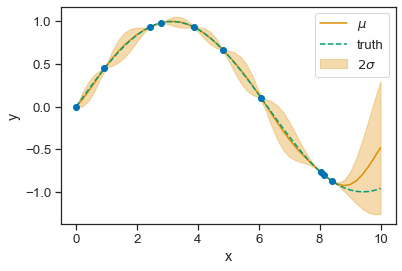

In [292]:
sigma = 1.0
length = 1.0

mean = np.zeros_like
kernel = lambda x, xp: squared_exponential(x, xp, sigma=length, length=length)

mu_pred, cov_pred = predict(x_pred, x, y, mean=mean, kernel=kernel)
sigma_pred = np.sqrt(np.diag(cov_pred))

plot_predictions(x, y, x_pred, mu_pred, sigma_pred)

### Observational noise

What if our observations of $f(x)$ have some additional independent white noise?

$$
\begin{bmatrix}
    \boldsymbol{y} \\ \boldsymbol{y}_\star
\end{bmatrix}
\sim \mathcal{N} \left(
\begin{bmatrix}
    \boldsymbol{m} \\ \boldsymbol{m}_\star
\end{bmatrix},
\begin{bmatrix}
    \boldsymbol{K} + \sigma_y^2\mathcal{I} & \boldsymbol{K}_\star \\
    \boldsymbol{K}_\star^T & \boldsymbol{K}_{\star\star}
\end{bmatrix}
\right),
$$

where $\mathcal{I}$ is the identity matrix.

We need to update `predict` to account for this noise. Using your solution from before, add `white_noise` to $\boldsymbol{K}$.

In [315]:
def white_noise(x, scale=1.0):
    """White noise to add to the diagonal of the covariance."""
    return scale**2 * np.eye(x.shape[0])


def predict(x_pred, x, y, *, mean, kernel, y_err=0.0):
    """TODO: Make a prediction from the GP governed by a given kernel.
    
    Args:
        x_pred (array_like): Array of x-values at which to make predictions.
        x (array_like): Array of x-values for known y-values.
        y (array_like): Array of known y-values.
        mean (callable): Mean function.
        kernel (callable): Kernel function.
        y_err (float): Observed uncertainty on y.

    Returns:
        np.ndarray: 1-D prediction mean.
        np.ndarray: 2-D prediction covariance.

    Hints:
        1. The scale of the white noise is given by y_err.
        2. We only want to add white noise to k(x, x).
    """
    Kxx = kernel(x, x) + jitter(x) + white_noise(x, scale=y_err)
    Kxp = kernel(x, x_pred)
    Kpp = kernel(x_pred, x_pred) + jitter(x_pred)
    Kxx_inv = np.linalg.inv(Kxx)
        
    mu_pred = mean(x_pred) + np.dot((y - mean(x)), np.dot(Kxx_inv, Kxp))
    cov_pred = Kpp - np.dot(Kxp.T, np.dot(Kxx_inv, Kxp))
    
    return mu_pred, cov_pred

In [316]:
y_err = 0.1
y = f(x) + y_err * rng.normal(size=num_obs)

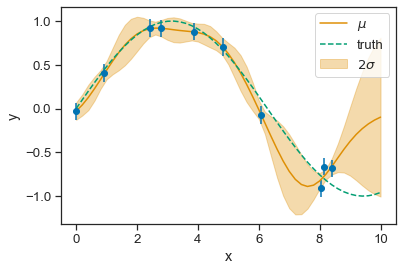

In [317]:
sigma = 1.0
length = 1.0

mean = np.zeros_like
kernel = lambda x, xp: squared_exponential(x, xp, sigma=length, length=length)

mu_pred, cov_pred = predict(x_pred, x, y, y_err=y_err, 
                            mean=mean, kernel=kernel)
sigma_pred = np.sqrt(np.diag(cov_pred))

plot_predictions(x, y, x_pred, mu_pred, sigma_pred, y_err=y_err)

## Radial velocities example

Let's consider the simplified radial velocity a star with a single orbiting planet,

$$v_r = A \sin\left(\frac{2\pi}{P}t\right)$$

where $A$ and $P$ are the amplitude and period.

In [26]:
def radial_velocity(t, amplitude=1.0, period=1.0):
    return amplitude * np.cos(2 * np.pi * t / period)

### Data

Lets consider the case where $A = 5$ (arbitrary units) and $P = 8\,\mathrm{d}$.

We observe 51 times over 24 days. However, there is some systematic noise messing with our measurements. We do not know the source of this noise, it could come from other orbiting bodies, activity of the star, or instrumentation issues.

Here, we inject the correlated noise using a sum of sine waves, but we will pretend we do not know its functional form.

In [329]:
truth = {
    'amplitude': 5.0,
    'period': 8.0,  # days
}

num_obs = 51
num_pred = 201
duration = 24.0  # days

t = np.linspace(0, duration, num_obs)
t_pred = np.linspace(0, duration, num_pred)

# Contribution from the planet
vr = radial_velocity(t, **truth)
vr_true = radial_velocity(t_pred, **truth)

# Injected correlated noise
w = 0.3  # Arbitrary scale of the noise
delta = lambda t: np.sin(w*t) + np.sin(w*t)**2 + np.sin(w*t)**3
vr += delta(t)
vr_true += delta(t_pred)

# Observed uncertainty on the velocities.
vr_err = 0.5
vr += vr_err * rng.normal(size=num_obs)

Plot the observation against the truths.

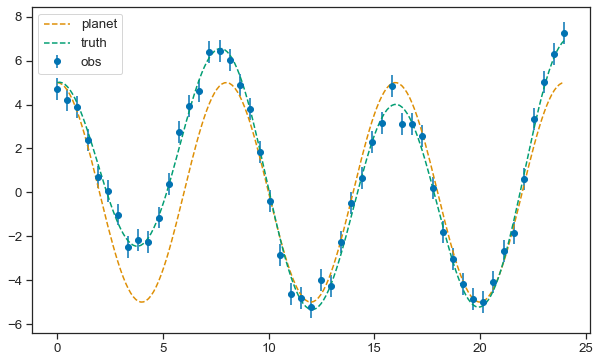

In [330]:
plt.figure(figsize=(10, 6))

plt.errorbar(t, vr, yerr=vr_err, fmt='o', label='obs')
plt.plot(t_pred, mean_true, linestyle='--', label='planet');

plt.plot(t_pred, vr_true, linestyle='--', label='truth');
plt.legend();

### Simple model

Using `emcee`, we will attempt to model this data with Bayes' theorem for the posterior probability of the model given the data,

$$p(\theta|v_r) \propto \mathcal{L}(v_r|\theta)\,\Pi(\theta)$$

where $\mathcal{L}(v_r|\theta)$ is the likelihood of the data, $v_r$ given the model parameters $\theta$, and $\Pi(\theta)$ is the prior likelihood of the model parameters.

The `log_prior` function defined below describes out prior expectation of the amplitude and period of the signal. The `log_likelihood` assumes known independent Gaussian noise characterised by $\sigma_v$,

$$\ln\mathcal{L}(v_r|\theta) = - \frac12 \sum_i \left\{ \left[\frac{v_{r}^{(i)} - f_{r}^{(i)}(t_i, \theta)}{\sigma_v}\right]^2 + 2\ln(\sigma_v) + \log(2\pi) \right\}$$

where $f_r^{(i)}(t_i, \theta) = A \sin\left(\frac{2\pi}{P}t_i\right)$. For this simple model, our parameters $\theta = \{A, P\}$.

In [104]:
def log_prior(params):
    a, p = params
    
    if 1.0 < a < 10.0 and 7.0 < p < 9.0:
        return 0.0
    return -np.inf


def log_likelihood(params, t, vr, vr_err):
    a, p = params
    # TODO: swap out s for obs err
    mu = radial_velocity(t, amplitude=a, period=p)
    return - 0.5 * np.sum(((vr - mu) / vr_err)**2 + 2*np.log(vr_err) + np.log(2*np.pi))


def log_prob(params, t, vr, vr_err):
    lprior = log_prior(params)
    if not np.isfinite(lprior):
        return -np.inf
    return lprior + log_likelihood(params, t, vr, vr_err)

We setup our sampler for this 2-dimensional model.

In [105]:
num_dim, num_walkers = 2, 100
sampler = emcee.EnsembleSampler(num_walkers, num_dim, log_prob, args=(t, vr, vr_err))

We choose some initial parameters in the bounds of our prior.

In [106]:
init_params = [5.5, 7.5]
shape = (num_walkers, num_dim)

# Broadcast parameters to sampler shape and add some random jitter
init_params = np.broadcast_to(init_params, shape) + 1e-6 * rng.normal(size=shape)

Run MCMC.

In [107]:
print("Running burn-in...")

state, lp, _ = sampler.run_mcmc(init_params, 1000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(state, 1000);

Running burn-in...
Running production...


Plot using the `corner` package, we see that the parameter estimations are biased and inaccurate.

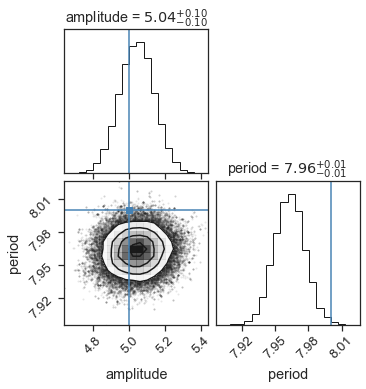

In [108]:
samples = sampler.flatchain
labels = ['amplitude', 'period']
truths = list(truth.values())
corner(samples, show_titles=True, labels=labels, truths=truths);

Let's plot the predictions against the truth.

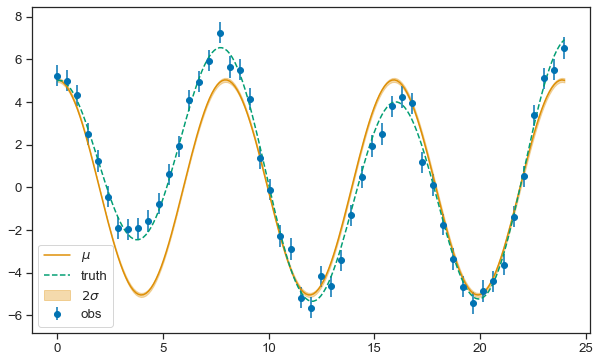

In [123]:
vr_pred = radial_velocity(t_pred, amplitude=samples[:, 0, None], period=samples[:, 1, None])

plt.figure(figsize=(10, 6))
plt.errorbar(t, vr, yerr=vr_err, fmt='o', label='obs')

vr_mean = vr_pred.mean(axis=0)
vr_sd = vr_pred.std(axis=0)
plt.plot(t_pred, vr_mean, label=r'$\mu$')
plt.fill_between(t_pred, vr_mean-vr_sd, vr_mean+vr_sd, alpha=0.33, color='C1', label=r'$2\sigma$')

plt.plot(t_pred, vr_true, linestyle='--', label='truth');
plt.legend();

### GP model

Now let's model using a GP. We will add the GP kernel parameters $\sigma$ and $\lambda$ to our model and choose a sensible prior for them. Our model parameters $\theta = \{A, P, \sigma, \lambda\}$.

Now, our GP likelihood is a little more complicated,

$$\ln\mathcal{L}(\boldsymbol{v}_r, \theta) = - \frac12 \left[ (\boldsymbol{v}_r - \boldsymbol{\mu})^T \cdot \boldsymbol{\Sigma}^{-1} \cdot (\boldsymbol{v}_r - \boldsymbol{\mu}) + \ln(|\boldsymbol{\Sigma}|) + N_\mathrm{obs}\ln(2\pi) \right]$$

where the mean is the radial velocity function, $\boldsymbol{\mu} = f_r(\boldsymbol{t}, \theta)$ and the covariance is the squared exponential plus some white noise, $\boldsymbol{\Sigma} = \boldsymbol{k}(t, t, \theta) + \sigma_v \mathcal{I}$.

In [331]:
def log_prior(params):
    """The prior now extends to GP kernel parameters sigma (s) and length (l)."""
    a, p, s, l = params
    if 1.0 < a < 10.0 and 7.0 < p < 9.0 and \
        0.1 < s < 5.0 and 1.0 < l < 10.0:
        return 0.0
    return -np.inf


def log_likelihood(params, t, vr, vr_err):
    """GP log likelihood."""
    a, p, s, l = params
    
    mu = radial_velocity(t, amplitude=a, period=p)
    cov = squared_exponential(t, t, sigma=s, length=l) + \
        white_noise(t, scale=vr_err) + \
        jitter(t)
    det = np.linalg.det(cov)
    
    return - 0.5 * (
        np.dot(np.dot((vr - mu).T, np.linalg.inv(cov)), (vr - mu)) + \
        np.log(det) + \
        t.shape[0] * np.log(2*np.pi)
    )


def log_prob(params, t, vr, vr_err):
    """Posterior log probability."""
    lprior = log_prior(params)
    if not np.isfinite(lprior):
        return -np.inf
    return lprior + log_likelihood(params, t, vr, vr_err)

Setup sampler, this time with 4 dimensions for the 4 model parameters.

In [332]:
num_dim, num_walkers = 4, 100
sampler = emcee.EnsembleSampler(num_walkers, num_dim, log_prob, args=(t, vr, vr_err))

We choose our initial parameters. For the GP kernel, this may be the expected amplitude and length-scale of the correlated noise.

In [333]:
init_params = [5.5, 7.5, 1.0, 5.0]
shape = (num_walkers, num_dim)
init_params = np.broadcast_to(init_params, shape) + 1e-6 * rng.normal(size=shape)

Run MCMC.

In [334]:
print("Running burn-in...")

state, lp, _ = sampler.run_mcmc(init_params, 1000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(state, 1000);

Running burn-in...
Running production...


The corner plot shows significant improvement.

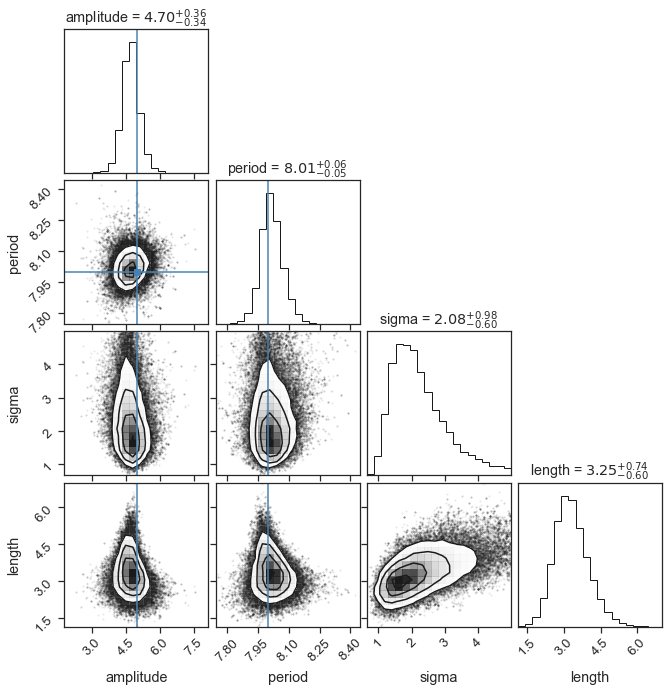

In [336]:
samples = sampler.flatchain
labels = ['amplitude', 'period', 'sigma', 'length']
truths = list(truth.values()) + [None, None]
corner(samples, show_titles=True, labels=labels, truths=truths);

### Predictions

We can check how well our model recovers the truth by making predictions. The `predict` function only works for a given mean and kernel function, but we have posterior samples for many forms of these funtions.

A GP is just a distribution over functions. From the posterior samples, we can get samples for the mean and kernel functions and combine them into the variable `gp`. `np.apply_along_axis` is a quick way to apply a function along an axis of an array. For samples from the posterior for `theta`, we obtain arrays of functions for the `mean` and `kernel` of the GP.

In [337]:
axis = 1
means = np.apply_along_axis(lambda theta: lambda t: radial_velocity(t, amplitude=theta[0], period=theta[1]), 
                            axis, samples)
kernels = np.apply_along_axis(lambda theta: lambda t, tp: squared_exponential(t, tp, sigma=theta[2], length=theta[3]), 
                            axis, samples)

gp = np.stack([means, kernels], axis=-1)

To make predictions for $v_r$, we sample from the multivariate normal governed by the predicted mean and covariance. This helper function does that for a given mean and kernel function, using our `predict` function from earlier.

In [338]:
def get_predictions(mean, kernel):
    mu_pred, cov_pred = predict(t_pred, t, vr, y_err=vr_err, mean=mean, kernel=kernel)
    return rng.multivariate_normal(mu_pred, cov_pred)

We choose a subsample from the posterior GP, because the following step can be slow.

In [339]:
num_subsamples = 1000
gp_subsample = rng.choice(gp, size=num_subsamples, replace=False)

From the subsamples of the GP, we get predictions for the radial velocity by again using `np.apply_along_axis`.

In [340]:
vr_pred = np.apply_along_axis(lambda gp: get_predictions(gp[0], gp[1]), axis, gp_subsample)

Let's plot these predictions.

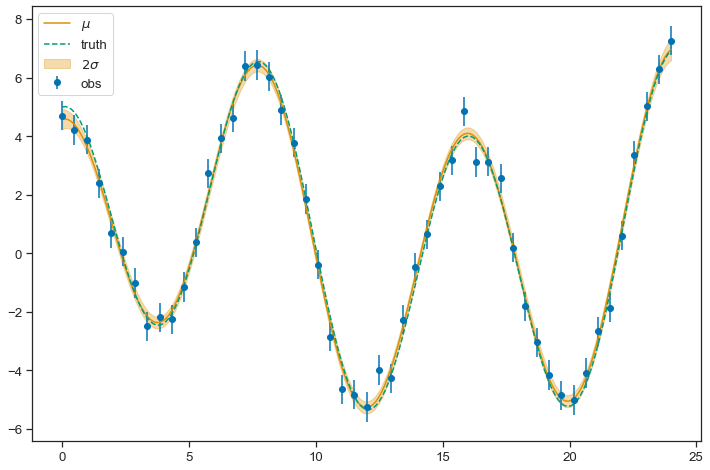

In [342]:
plt.figure(figsize=(12, 8))
plt.errorbar(t, vr, yerr=vr_err, fmt='o', label='obs')

vr_mean = vr_pred.mean(axis=0)
vr_sd = vr_pred.std(axis=0)
plt.plot(t_pred, vr_mean, label=r'$\mu$')
plt.fill_between(t_pred, vr_mean-vr_sd, vr_mean+vr_sd, alpha=0.33, color='C1', label=r'$2\sigma$')

plt.plot(t_pred, vr_true, linestyle='--', label='truth');
plt.legend();